In [352]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [353]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [354]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}

In [355]:
# Build dataset
def build_dataset(words: list[str], print_examples: int = 0) -> tuple[torch.Tensor, torch.Tensor]:
    block_size = 3 # Context length: number of characters taken to predict the next one
    X, Y = [], []
    for i, w in enumerate(words):
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if i < print_examples:
                print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [356]:
X, Y = build_dataset(words, 5)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [357]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [358]:
# Embedding lookup table
C = torch.randn((27, 2))

In [359]:
# Parameters
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [360]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [361]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # Number of parameters in total

3481

In [362]:
# Forward pass
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [363]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h)
h.shape

tensor([[ 0.9702, -0.9597, -0.7471,  ..., -0.7479, -0.4891, -0.9671],
        [ 0.9082, -0.9986,  0.9499,  ..., -0.9865,  0.1521, -0.1285],
        [ 0.9522, -0.9740, -0.9825,  ...,  0.3285, -0.6447, -0.7986],
        ...,
        [ 0.8984, -0.9562,  0.9397,  ..., -0.9321,  0.4322, -0.6911],
        [ 0.9560,  0.6179, -0.9530,  ...,  0.2508, -0.1723, -0.9743],
        [ 0.9744,  0.4931, -0.6755,  ..., -0.5598, -0.4297, -0.9883]])


torch.Size([228146, 100])

In [364]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [365]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [366]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(13.8617)

In [367]:
loss = F.cross_entropy(logits, Y)
loss

tensor(13.8617)

In [368]:
for p in parameters:
    p.requires_grad = True

In [369]:
# Learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [370]:
# Find optimal learning rate
lri = []
lossi = []

for i in range(1000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

4.9296393394470215


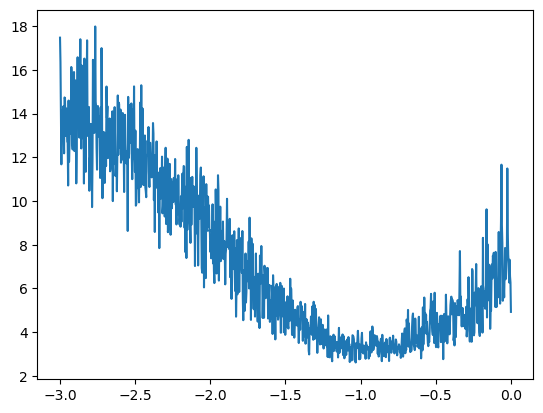

In [371]:
plt.plot(lri, lossi)

In [372]:
# Training
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.6233012676239014


In [373]:
# Create the data sets
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.8*len(words))

# Training split (80%)
Xtr, Ytr = build_dataset(words[:n1])

# Dev/validation split (10%)
Xdev, Ydev = build_dataset(words[n1:n2])

# Test split (10%)
Xte, Yte = build_dataset(words[n2:])